In [1]:
%matplotlib inline

In [2]:
from astropy import units as u
from astropy.coordinates.angle_utilities import angular_separation

import matplotlib.pyplot as plt
import numpy as np

from ctapipe.io import event_source
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument.camera import CameraGeometry
from ctapipe.calib import CameraCalibrator
from ctapipe.reco.HillasReconstructor import HillasReconstructor
from ctapipe.image.hillas import hillas_parameters
from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.utils import linalg
from ctapipe.utils import datasets

In [3]:
# MC dataset
filename = datasets.get_dataset_path("gamma_test_large.simtel.gz")

In [4]:
# get source events in MC dataset
source = event_source(filename, allowed_tels={1, 2, 3, 4})
reco = HillasReconstructor()
calib = CameraCalibrator(r1_product='HESSIOR1Calibrator')

In [5]:
off_angles = []
for event in source:

    # calibrating the event
    calib.calibrate(event)
    
    hillas_params = {}
    # pointing direction of the telescopes
    point_azimuth = {}
    point_altitude = {}
    
    subarray = event.inst.subarray
    
    # get hillas params for each event in different telescopes
    for tel_id in event.dl0.tels_with_data:

        # telescope pointing direction
        point_azimuth[tel_id] = event.mc.tel[tel_id].azimuth_raw * u.rad
        point_altitude[tel_id] = event.mc.tel[tel_id].altitude_raw * u.rad
        #        print(point_azimuth,point_altitude)

        # Camera Geometry required for hillas parametrization
        camgeom = subarray.tel[tel_id].camera

        # note the [0] is for channel 0 which is high-gain channel
        image = event.dl1.tel[tel_id].image[0]

        # Cleaning  of the image
        cleaned_image = image
        # create a clean mask of pixels above the threshold
        cleanmask = tailcuts_clean(
            camgeom, image, picture_thresh=10, boundary_thresh=5
        )
        # set all rejected pixels to zero
        cleaned_image[~cleanmask] = 0

        # Calulate hillas parameters
        # It fails for empty pixels
        try:
            hillas_params[tel_id] = hillas_parameters(camgeom, cleaned_image)
        except:
            pass

    if len(hillas_params) < 2:
        continue

    reco_result = reco.predict(hillas_params, event.inst, point_altitude, point_azimuth)

    # get angular offset between reconstructed shower direction and MC
    # generated shower direction
    off_angle = angular_separation(event.mc.az, event.mc.alt, reco_result.az, reco_result.alt)

    # Appending all estimated off angles
    off_angles.append(off_angle.to(u.deg).value)

/Users/mackaiver/Development/ctapipe/ctapipe/image/hillas.py:571: RuntimeWarning: invalid value encountered in sqrt
  width = np.sqrt((vy2 + vx2 - z) / 2.0)
/Users/mackaiver/Development/ctapipe/ctapipe/image/hillas.py:571: RuntimeWarning: invalid value encountered in sqrt
  width = np.sqrt((vy2 + vx2 - z) / 2.0)


In [6]:
# calculate theta square for angles which are not nan
off_angles = np.array(off_angles)
thetasquare = off_angles[np.isfinite(off_angles)]**2

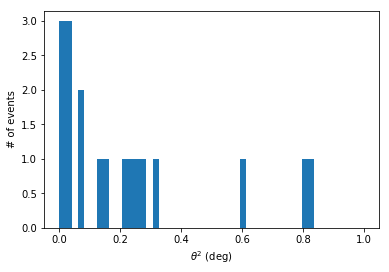

In [7]:
# plot 
plt.hist(thetasquare, bins=np.linspace(0, 1, 50))
plt.xlabel(r'$\theta^2$ (deg)')
plt.ylabel("# of events")
plt.show()